## Importing Libraries

In [39]:
import numpy as np
import pandas as pd

import sys
import os
from dataprep.eda import create_report

# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join("..","src")))

from data_ingestion import data_ingestion
from feature_engineering import *

# Load Data

In [40]:
scada_file = 'scada_data.csv'
fault_file = 'fault_data.csv'
price_file = 'rpt.00013060.0000000000000000.DAMLZHBSPP_2014.xlsx'

# Load SCADA data
scada_data = pd.read_csv("../data/raw/"+scada_file)
scada_data['DateTime'] = pd.to_datetime(scada_data['DateTime'], format='%m/%d/%Y %H:%M', errors='coerce')

# Load fault data
fault_data = pd.read_csv("../data/raw/"+fault_file)
fault_data['DateTime'] = pd.to_datetime(fault_data['DateTime'], format='%Y-%m-%d %H:%M', errors='coerce')

# Load and process price data
sheet_names = ['Jan_1', 'Feb_2', 'Mar_3', 'Apr_4', 'May_5', 'Jun_6', 'Jul_7', 'Aug_8', 'Sep_9', 'Oct_10', 'Nov_11', 'Dec_12']
price_data = data_ingestion(price_file, sheet_names=sheet_names)
price_data_houston = preprocess_price_data(price_data)

# Plots

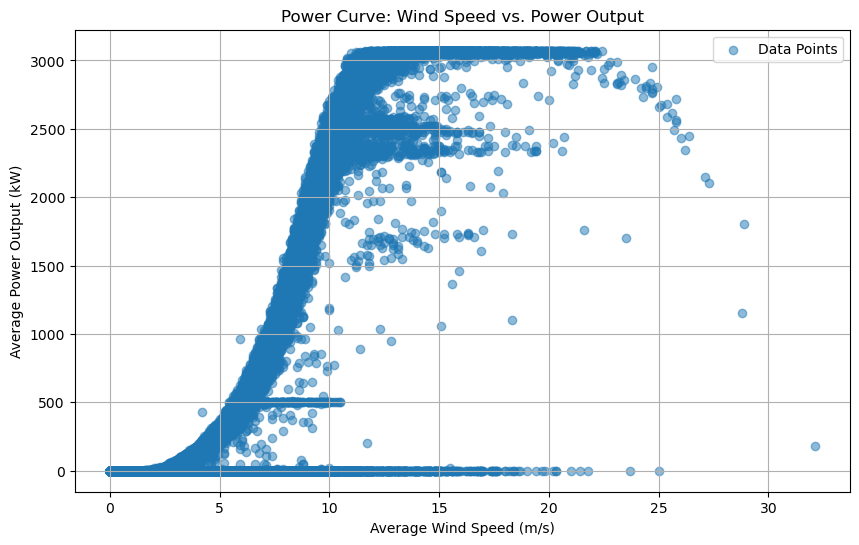

In [42]:
import matplotlib.pyplot as plt

# Extract relevant columns for the power curve
wind_speed = scada_data['WEC: ava. windspeed']
power_output = scada_data['WEC: ava. Power']

# Plotting the power curve
plt.figure(figsize=(10, 6))
plt.scatter(wind_speed, power_output, alpha=0.5, label="Data Points")
plt.title("Power Curve: Wind Speed vs. Power Output")
plt.xlabel("Average Wind Speed (m/s)")
plt.ylabel("Average Power Output (kW)")
plt.grid(True)
plt.legend()
plt.show()


<Axes: xlabel='DateTime'>

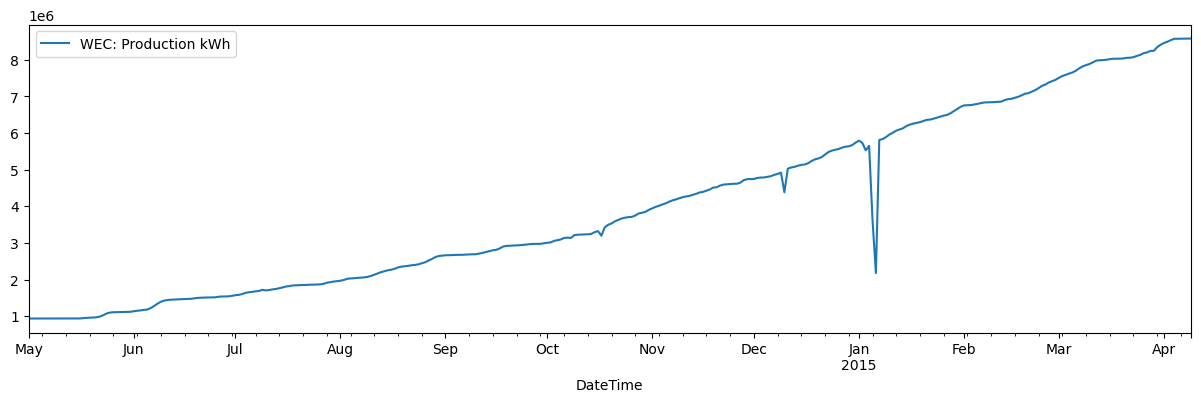

In [43]:
scada_data.resample('D', on='DateTime').mean().plot(y='WEC: Production kWh', figsize=(15,4))

<Axes: title={'center': 'Wind Turbine Faults'}, xlabel='DateTime', ylabel='Fault Counts'>

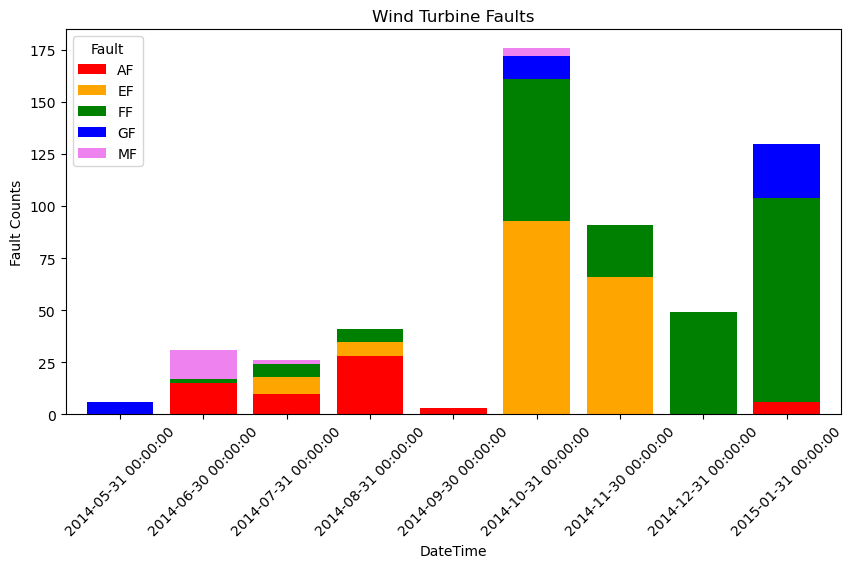

In [44]:
c = ['red', 'orange', 'green', 'blue', 'violet']
fault_data.resample('M', on='DateTime').Fault.value_counts().unstack().plot.bar(stacked=True, width=0.8, figsize=(10,5), color=c, rot=45,
                                                                              title='Wind Turbine Faults', ylabel='Fault Counts')

# Calculate Revenue

In [45]:
# Define overlapping range
scada_datetime_range = (scada_data['DateTime'].min(), scada_data['DateTime'].max())
price_datetime_range = (price_data_houston['DateTime'].min(), price_data_houston['DateTime'].max())
overlap_start = max(scada_datetime_range[0], price_datetime_range[0])
overlap_end = min(scada_datetime_range[1], price_datetime_range[1])

# Filter SCADA data for overlapping range
filtered_scada = preprocess_scada_data(scada_data, overlap_start, overlap_end)
filtered_price = price_data_houston[
    (price_data_houston['DateTime'] >= overlap_start) & (price_data_houston['DateTime'] <= overlap_end)
]

# Calculate revenue
final_scada, total_revenue = calculate_revenue(filtered_scada, filtered_price)

# Output results
total_revenue, final_scada[['DateTime', 'WEC: Production kWh', 'Settlement Point Price', 'Revenue']].head()

(3181248756.51731,
              DateTime  WEC: Production kWh  Settlement Point Price  \
 0 2014-05-01 01:59:00               939053                   34.19   
 1 2014-05-01 01:59:00               939053                   34.19   
 2 2014-05-01 01:59:00               939053                   34.19   
 3 2014-05-01 01:59:00               939053                   34.19   
 4 2014-05-01 01:59:00               939053                   34.19   
 
        Revenue  
 0  32106.22207  
 1  32106.22207  
 2  32106.22207  
 3  32106.22207  
 4  32106.22207  )

In [46]:
filtered_price

,Delivery Date,Hour Ending,Repeated Hour Flag,Settlement Point,Settlement Point Price,DateTime
40307,05/01/2014,01:59,N,HB_HOUSTON,34.19,2014-05-01 01:59:00
40321,05/01/2014,02:59,N,HB_HOUSTON,29.70,2014-05-01 02:59:00
40335,05/01/2014,03:59,N,HB_HOUSTON,29.67,2014-05-01 03:59:00
40349,05/01/2014,04:59,N,HB_HOUSTON,29.73,2014-05-01 04:59:00
40363,05/01/2014,05:59,N,HB_HOUSTON,30.06,2014-05-01 05:59:00
...,...,...,...,...,...,...
122557,12/31/2014,19:59,N,HB_HOUSTON,63.99,2014-12-31 19:59:00
122571,12/31/2014,20:59,N,HB_HOUSTON,39.67,2014-12-31 20:59:00
122585,12/31/2014,21:59,N,HB_HOUSTON,33.43,2014-12-31 21:59:00
122599,12/31/2014,22:59,N,HB_HOUSTON,30.08,2014-12-31 22:59:00


# Combine data and extra feature engineering

In [47]:
# Doing an right(fault) outer join to make sure that date and time data match for fault and scada dataset.
combined_df = final_scada.merge(fault_data, on="DateTime", how="outer")

In [48]:
combined_df['Fault'] = combined_df['Fault'].fillna('NF')

In [49]:
# Use dataprep.eda package to auto-generate data analysis report
eda_report = create_report(combined_df)

# Saving it to the eda_report.html

eda_report.save("../reports/eda_report.html")

  0%|          | 0/19027 [00:00<?, ?it/s]

d:\Anaconda\envs\fu24_block2_team3_env\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
d:\Anaconda\envs\fu24_block2_team3_env\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
d:\Anaconda\envs\fu24_block2_team3_env\lib\site-packages\dataprep\eda\distribution\render.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({col: [nrows - npresent]}, index=["Others"]))
d:\Anaconda\envs\fu24_block2_team3_env\lib\site-packages\dataprep\eda\distribution\render.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({col: [nrows - npresent]}, index=["Others"]))
d:\Anaconda\envs\fu2

Report has been saved to ..\reports\eda_report.html!


In [50]:
# Create temporal/seasonal features such as day of the week, is weekend, is high demand season(6,7,8)
df = create_temporal_features(combined_df)
#df[df['Is_Weekend'] == 1]
df

,DateTime,Time_x,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Inverter averages,Inverter std dev,Settlement Point Price,Revenue,Time_y,Fault,Month,Day_of_Week,Is_Weekend,Is_High_Demand_Season
0,2014-05-01 01:59:00,1.398924e+09,0.0,6.7,10.5,1.9,0.0,0.02,0.0,0.0,...,25.272728,1.103713,34.19,32106.22207,NaN,NF,5,3,0,0
1,2014-05-01 01:59:00,1.398925e+09,0.0,3.7,9.1,1.1,0.0,0.04,0.0,0.0,...,25.272728,1.103713,34.19,32106.22207,NaN,NF,5,3,0,0
2,2014-05-01 01:59:00,1.398925e+09,0.0,3.4,8.9,0.7,0.0,0.05,0.0,0.0,...,25.272728,1.103713,34.19,32106.22207,NaN,NF,5,3,0,0
3,2014-05-01 01:59:00,1.398926e+09,0.0,4.5,8.7,1.1,0.0,0.06,0.0,0.0,...,25.272728,1.103713,34.19,32106.22207,NaN,NF,5,3,0,0
4,2014-05-01 01:59:00,1.398926e+09,0.0,7.6,9.3,2.4,0.0,0.02,0.0,0.0,...,25.272728,1.103713,34.19,32106.22207,NaN,NF,5,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34048,2015-01-14 23:00:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.421298e+09,AF,1,2,0,1
34049,2015-01-14 23:09:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.421299e+09,AF,1,2,0,1
34050,2015-01-15 22:50:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.421384e+09,AF,1,3,0,1
34051,2015-01-15 23:00:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.421384e+09,AF,1,3,0,1


In [51]:
df = calculate_fault_frequency(df, 'Fault')
df

,DateTime,Time_x,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Settlement Point Price,Revenue,Time_y,Fault,Month,Day_of_Week,Is_Weekend,Is_High_Demand_Season,Fault_count,Days_Since_Last_Fault
0,2014-05-01 01:59:00,1.398924e+09,0.0,6.7,10.5,1.9,0.0,0.02,0.0,0.0,...,34.19,32106.22207,NaN,NF,5,3,0,0,1,33499
1,2014-05-01 01:59:00,1.398925e+09,0.0,3.7,9.1,1.1,0.0,0.04,0.0,0.0,...,34.19,32106.22207,NaN,NF,5,3,0,0,2,33498
2,2014-05-01 01:59:00,1.398925e+09,0.0,3.4,8.9,0.7,0.0,0.05,0.0,0.0,...,34.19,32106.22207,NaN,NF,5,3,0,0,3,33497
3,2014-05-01 01:59:00,1.398926e+09,0.0,4.5,8.7,1.1,0.0,0.06,0.0,0.0,...,34.19,32106.22207,NaN,NF,5,3,0,0,4,33496
4,2014-05-01 01:59:00,1.398926e+09,0.0,7.6,9.3,2.4,0.0,0.02,0.0,0.0,...,34.19,32106.22207,NaN,NF,5,3,0,0,5,33495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34048,2015-01-14 23:00:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.421298e+09,AF,1,2,0,1,58,4
34049,2015-01-14 23:09:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.421299e+09,AF,1,2,0,1,59,3
34050,2015-01-15 22:50:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.421384e+09,AF,1,3,0,1,60,2
34051,2015-01-15 23:00:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.421384e+09,AF,1,3,0,1,61,1


In [52]:
df = calculate_maintenance_cost(df)
df

,DateTime,Time_x,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Revenue,Time_y,Fault,Month,Day_of_Week,Is_Weekend,Is_High_Demand_Season,Fault_count,Days_Since_Last_Fault,Maintenance_Cost
0,2014-05-01 01:59:00,1.398924e+09,0.0,6.7,10.5,1.9,0.0,0.02,0.0,0.0,...,32106.22207,NaN,NF,5,3,0,0,1,33499,50000
1,2014-05-01 01:59:00,1.398925e+09,0.0,3.7,9.1,1.1,0.0,0.04,0.0,0.0,...,32106.22207,NaN,NF,5,3,0,0,2,33498,50000
2,2014-05-01 01:59:00,1.398925e+09,0.0,3.4,8.9,0.7,0.0,0.05,0.0,0.0,...,32106.22207,NaN,NF,5,3,0,0,3,33497,50000
3,2014-05-01 01:59:00,1.398926e+09,0.0,4.5,8.7,1.1,0.0,0.06,0.0,0.0,...,32106.22207,NaN,NF,5,3,0,0,4,33496,50000
4,2014-05-01 01:59:00,1.398926e+09,0.0,7.6,9.3,2.4,0.0,0.02,0.0,0.0,...,32106.22207,NaN,NF,5,3,0,0,5,33495,50000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34048,2015-01-14 23:00:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.421298e+09,AF,1,2,0,1,58,4,150000
34049,2015-01-14 23:09:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.421299e+09,AF,1,2,0,1,59,3,150000
34050,2015-01-15 22:50:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.421384e+09,AF,1,3,0,1,60,2,150000
34051,2015-01-15 23:00:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.421384e+09,AF,1,3,0,1,61,1,150000


In [53]:
df = energy_production_metrics(df, 'WEC: Production kWh')
df

,DateTime,Time_x,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Time_y,Fault,Month,Day_of_Week,Is_Weekend,Is_High_Demand_Season,Fault_count,Days_Since_Last_Fault,Maintenance_Cost,Pre_Sold_Production
0,2014-05-01 01:59:00,1.398924e+09,0.0,6.7,10.5,1.9,0.0,0.02,0.0,0.0,...,NaN,NF,5,3,0,0,1,33499,50000,751242.4
1,2014-05-01 01:59:00,1.398925e+09,0.0,3.7,9.1,1.1,0.0,0.04,0.0,0.0,...,NaN,NF,5,3,0,0,2,33498,50000,751242.4
2,2014-05-01 01:59:00,1.398925e+09,0.0,3.4,8.9,0.7,0.0,0.05,0.0,0.0,...,NaN,NF,5,3,0,0,3,33497,50000,751242.4
3,2014-05-01 01:59:00,1.398926e+09,0.0,4.5,8.7,1.1,0.0,0.06,0.0,0.0,...,NaN,NF,5,3,0,0,4,33496,50000,751242.4
4,2014-05-01 01:59:00,1.398926e+09,0.0,7.6,9.3,2.4,0.0,0.02,0.0,0.0,...,NaN,NF,5,3,0,0,5,33495,50000,751242.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34048,2015-01-14 23:00:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.421298e+09,AF,1,2,0,1,58,4,150000,NaN
34049,2015-01-14 23:09:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.421299e+09,AF,1,2,0,1,59,3,150000,NaN
34050,2015-01-15 22:50:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.421384e+09,AF,1,3,0,1,60,2,150000,NaN
34051,2015-01-15 23:00:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.421384e+09,AF,1,3,0,1,61,1,150000,NaN
